Our first graphic is a correlation heatmap of our cleaned data for white and red wine.  The wine data is NOT combined because in my opinion people have different flavor expectations for red and white wine and thus the the same quality in each wine could have different impacts on perception of quality.

NAs in Red: False 

NAs in White: False 



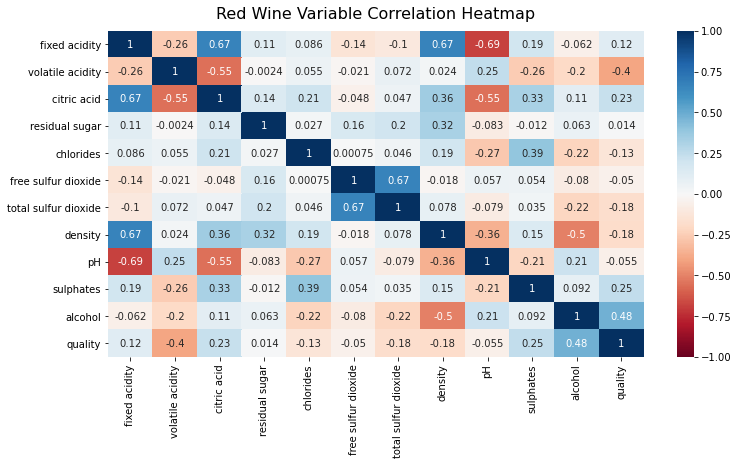

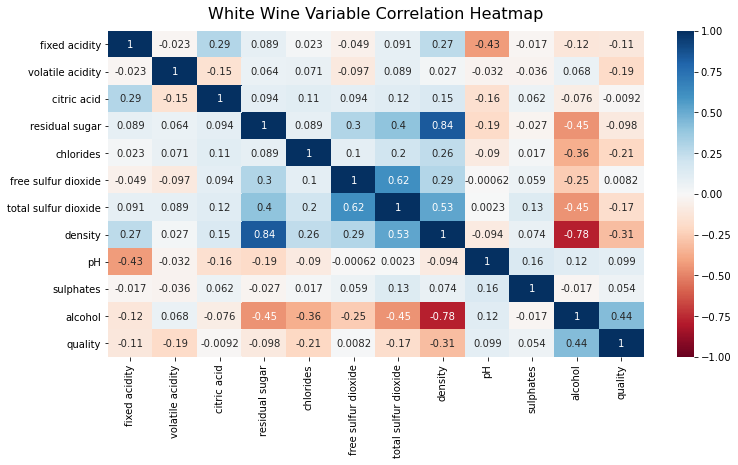

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import svm
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import kendalltau
import time

#Accesses and reads data from csv 
redWine = pd.read_csv('winequality-red.csv', sep = ';')
redWine.head()
whiteWine = pd.read_csv('winequality-white.csv', sep = ';')
whiteWine.head()

#Cleaning the data
redWine.drop_duplicates(inplace=True)
redWine.drop_duplicates(inplace=True)
#Checks to male sure no leftover non applicable terms in the data sets
print('NAs in Red:', redWine.isna().any().any(),'\n')
print('NAs in White:', whiteWine.isna().any().any(),'\n')

#creates picture w/ designated size (12,6)
plt.figure(figsize=(12,6))
#creates heatmap that correlates the red wine data, sets range from -1 to 1, 
#and sets the color
heatmap = sns.heatmap(redWine.corr(), vmin = -1, vmax=1, annot = True, cmap = 'RdBu')
heatmap.set_title('Red Wine Variable Correlation Heatmap', fontdict={'fontsize':16}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
#creates picture w/ designated size (12,6)
plt.figure(figsize=(12,6))
#creates heatmap that correlates the white wine data, sets range from -1 to 1, 
#and sets the color
heatmap = sns.heatmap(whiteWine.corr(), vmin = -1, vmax=1, annot = True, cmap = 'RdBu')
heatmap.set_title('White Wine Variable Correlation Heatmap', fontdict={'fontsize':16}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')


Next we create groups of poor, mediocre, and good for both wine types.  We then can make histograms showing both raw quality scores and grouped. Based off of this visual, an assumption could be made that white wines are more popular or appealing to general tastes by looking at the relation of good to mediocre scores for each type.  I also noticed that we do have significantly more data for white wines than we do for red wines.

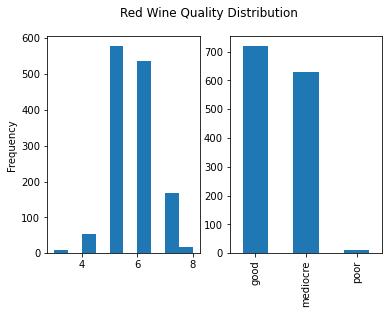

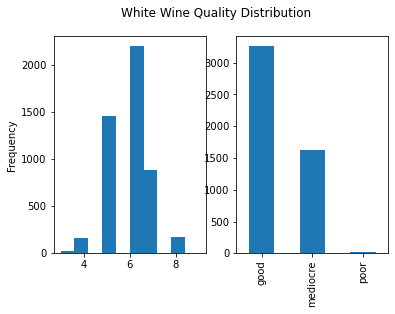

In [61]:
#create subgroups of red wine quality with scores of 0 to 3 being poor, 
#4 to 5 being mediocre, and 6+ being good
x = []
for element in redWine.quality:
    if ((element >=0) and (element <4)):
        x.append('poor')
    elif ((element >= 4) and (element<6)):
        x.append('mediocre')
    else:
        x.append('good')

redWine['grouped quality'] = x

plt.figure()
#creates histogram of raw red wine quality scores
plt.subplot(121)
redWine.quality.plot(kind='hist')
#creates histogram for grouped red wine quality scores
plt.subplot(122)
groupedRWHist = redWine['grouped quality'].value_counts()
groupedRWHist.plot(kind="bar")

plt.suptitle('Red Wine Quality Distribution')

plt.show()

#create subgroups of white wine quality with scores of 0 to 3 being poor, 
#4 to 5 being mediocre, and 6+ being good
x = []
for element in whiteWine.quality:
    if ((element >=0) and (element <4)):
        x.append('poor')
    elif ((element >= 4) and (element<6)):
        x.append('mediocre')
    else:
        x.append('good')

whiteWine['grouped quality'] = x

plt.figure()
#creates histogram of raw white wine quality scores
plt.subplot(121)
whiteWine.quality.plot(kind='hist')
#creates histogram for grouped white wine quality scores
plt.subplot(122)
groupedWWHist = whiteWine['grouped quality'].value_counts()
groupedWWHist.plot(kind="bar")

plt.suptitle('White Wine Quality Distribution')

plt.show()

Text(0.5, 0.98, 'Violin Plots for White Wine Quality vs Other Characteristics')

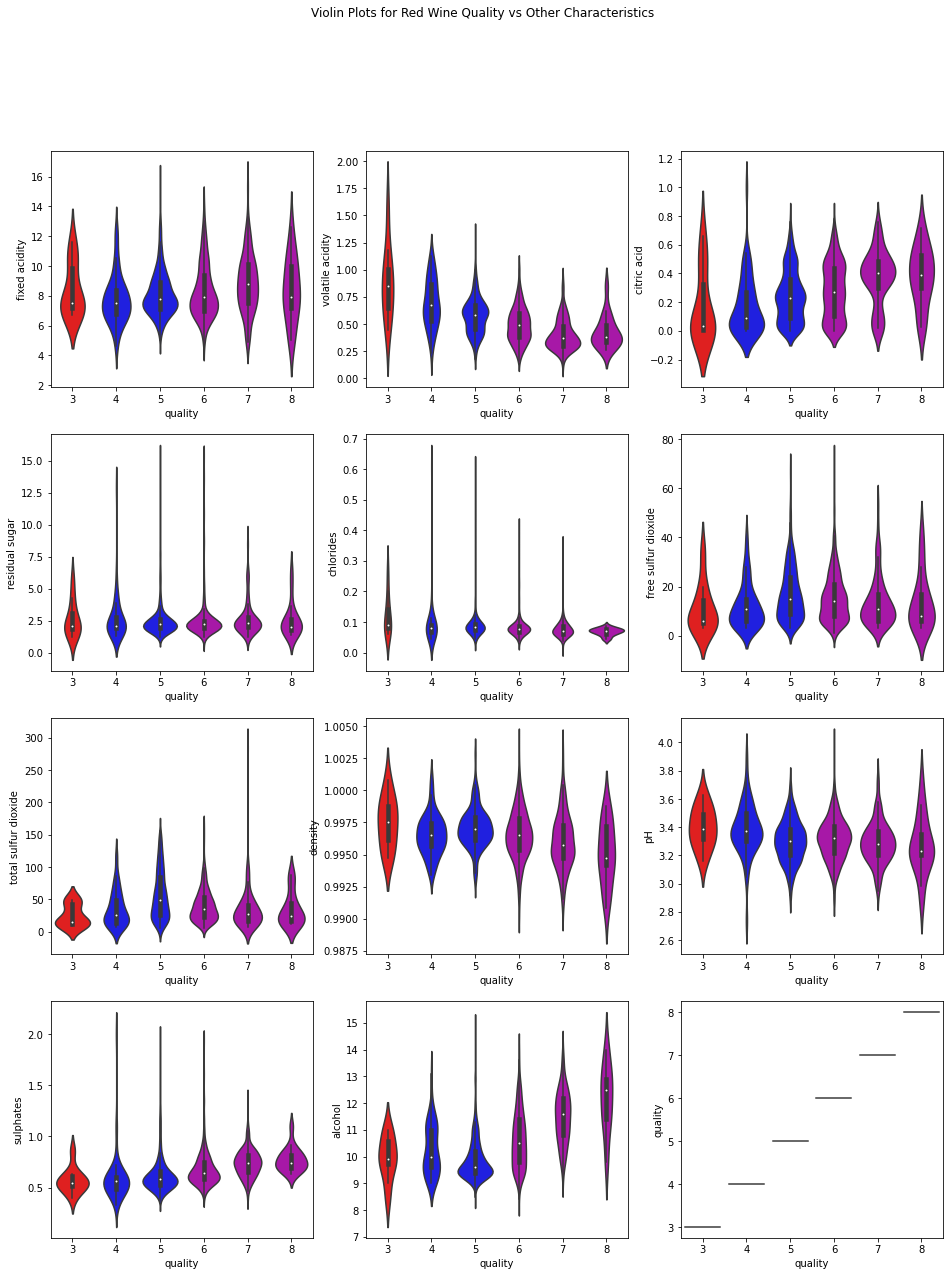

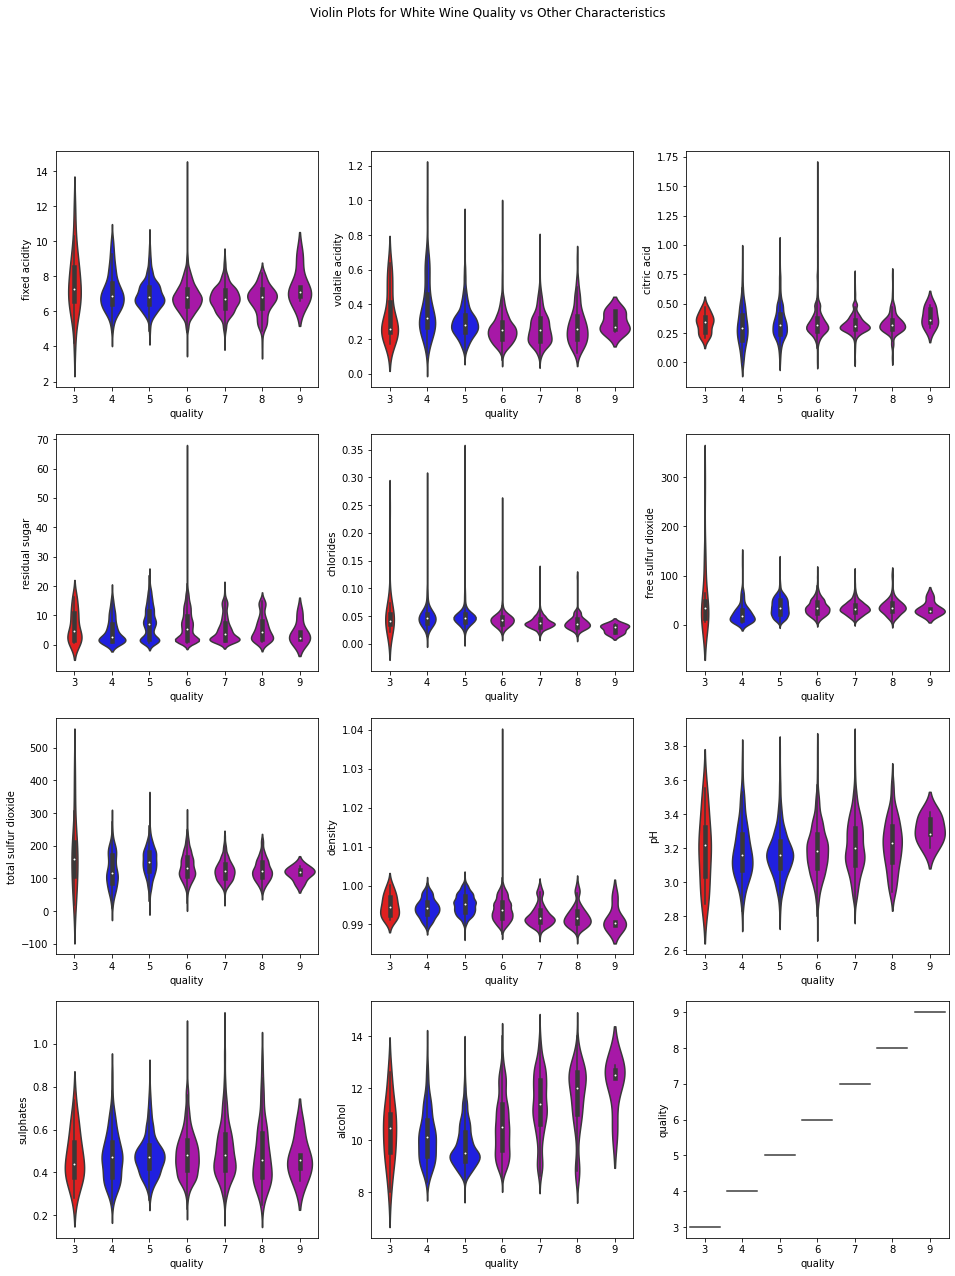

In [56]:
#Setting up variables to iterate through the characteristic categories in our 
#loop creating the subplots
col = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar",
       "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
       "pH", "sulphates", "alcohol", "quality"]

#Creating a color palette with poor, mediocre, and good grouped.  Poor is red, 
#mediocre is blue, and good is magenta
myPal = {1: "r", 2: "r", 3: "r", 4: "b", 5: "b", 6: "m", 7: "m", 8: "m", 9: "m"}

#Red wine figures

fig, axes = plt.subplots(4, 3, figsize=(16,20))
i=0
for x in range(4):
    for y in range(3):
        sns.violinplot(x="quality", y=col[i], data=redWine, ax=axes[x, y], palette=myPal)
        i+=1
        
plt.suptitle('Violin Plots for Red Wine Quality vs Other Characteristics')


fig, axes = plt.subplots(4, 3, figsize=(16,20))
i=0
for x in range(4):
    for y in range(3):
        sns.violinplot(x="quality", y=col[i], data=whiteWine, ax=axes[x, y], palette=myPal)
        i+=1
plt.suptitle('Violin Plots for White Wine Quality vs Other Characteristics')

I chose a violin plot over a box plot because while a box plot might show more quantitative data, a violin plot shows the distribution of the characteristic values for each quality rating.  I believe this visual gives more information and clarity on the impact characteristcs have on quality.  One flaw of violin plots is that for smaller sample sizes the estimated distribution can appear much smoother than the actual distribution.  In our case, this could make our red wine figures less reliable.

Machine Learning: Logistic Regression

In [63]:
#Target features and arrays initialzed first

#Exact quality values
targetRedQual = redWine.quality
targetWhiteQual = whiteWine.quality
featuresRed = redWine.iloc[:, :-2]
#Grouped quality values
targetRedGroupedQual = redWine['grouped quality']
targetWhiteGroupedQual = whiteWine['grouped quality']
featuresWhite = whiteWine.iloc[:, :-2]

#Selecting features

#It does not matter if we use white or red here and we do not need them
#seperated because both types of wines will have the same features
features = redWine.iloc[:, :-2]

#featuresSelected = col
#selectedFeaturesRed = featuresRed[featuresSelected]
#selectedFeaturesWhite = featuresWhite[featuresSelected]

featuresSelected = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar",
       "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
       "pH", "sulphates", "alcohol"]
#featureNames = [x for x in features.columns]
#for name in featureNames:
#    coef,p = kendalltau(features[f'{name}'], targetRedQual)
#    if p < .01:
#        featuresSelected.append(name)
       #print(f'NAME:{name}, COEF:{coef}, P-VAL: {p}','\n')

#selectedFeatures = all_wines[features_selected]
selectedFeaturesRed = featuresRed[featuresSelected]
selectedFeaturesWhite = featuresWhite[featuresSelected]


Red Logistic Regression

The (3-9 Scale) LogReg Score for Red Wine is: 58.330000000000005% 

The (grouped) LogReg Score for Red Wine is: 71.81% 



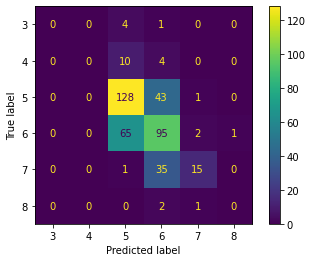

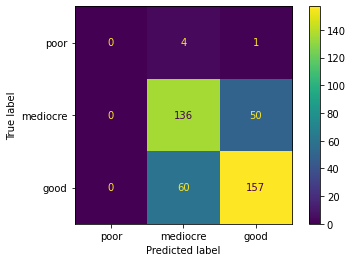

In [65]:
#Prior we have listed our quality scale as 1-10, however since all of our
#values fall between 3 and 9 a 3-9 scale is the same

#Begin a timer
startTime = time.time()

#First we'll do the logistic regression for quality ratings of 3-9
featureTrain,featureTest,targetTrain,targetTest = train_test_split(selectedFeaturesRed,
                                                      targetRedQual,
                                                      test_size=0.3,
                                                      random_state=1111)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))
pipe.fit(featureTrain, targetTrain)

log_score_sel_qual = pipe.score(featureTest,targetTest)

print(f'The (3-9 Scale) LogReg Score for Red Wine is: {log_score_sel_qual.round(4)*100}%','\n')

#Creates a confusion matrix visualizing how well our algorithm correctly predicted the quality rating
#Correctly predicted qualities will be along the main diagonal
#The heat scale goes from purple (0 labels predicted or true) to its highest values as yellow
confusionMatrixPlot = sklearn.metrics.plot_confusion_matrix(pipe, featureTest, targetTest)

#Next we repeat those steps except for the grouped quality ratings
featureTrain,featureTest,targetTrain,targetTest = train_test_split(selectedFeaturesRed,
                                                      targetRedGroupedQual,
                                                      test_size=0.3,
                                                      random_state=1111)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))
pipe.fit(featureTrain, targetTrain)

log_score_sel_qual = pipe.score(featureTest,targetTest)

print(f'The (grouped) LogReg Score for Red Wine is: {log_score_sel_qual.round(4)*100}%','\n')
labels = ['poor','mediocre','good']
confusionMatrixPlot = sklearn.metrics.plot_confusion_matrix(pipe, featureTest, targetTest, labels = labels)

White Logistic Regression

The (3-9 Scale) LogReg Score for White Wine is: 53.33% 

The (grouped) LogReg Score for White Wine is: 73.54% 



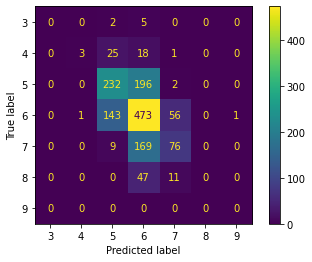

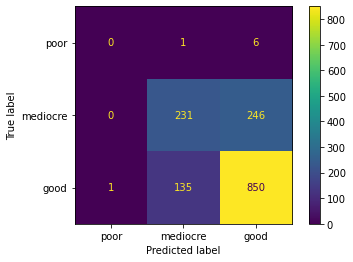

In [67]:
#Proccess is the same for white as it was for red
#Prior we have listed our quality scale as 1-10, however since all of our
#values fall between 3 and 9 a 3-9 scale is the same

#Begin a timer
startTime = time.time()

featureTrain,featureTest,targetTrain,targetTest = train_test_split(selectedFeaturesWhite,
                                                      targetWhiteQual,
                                                      test_size=0.3,
                                                      random_state=1111)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))
pipe.fit(featureTrain, targetTrain)

log_score_sel_qual = pipe.score(featureTest,targetTest)

print(f'The (3-9 Scale) LogReg Score for White Wine is: {log_score_sel_qual.round(4)*100}%','\n')

#Creates a confusion matrix visualizing how well our algorithm correctly predicted the quality rating
#Correctly predicted qualities will be along the main diagonal
#The heat scale goes from purple (0 labels predicted or true) to its highest values as yellow
confusionMatrixPlot = sklearn.metrics.plot_confusion_matrix(pipe, featureTest, targetTest)

#Next we repeat those steps except for the grouped quality ratings
featureTrain,featureTest,targetTrain,targetTest = train_test_split(selectedFeaturesWhite,
                                                      targetWhiteGroupedQual,
                                                      test_size=0.3,
                                                      random_state=1111)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))
pipe.fit(featureTrain, targetTrain)

log_score_sel_qual = pipe.score(featureTest,targetTest)

print(f'The (grouped) LogReg Score for White Wine is: {log_score_sel_qual.round(4)*100}%','\n')

confusionMatrixPlot = sklearn.metrics.plot_confusion_matrix(pipe, featureTest, targetTest, labels = labels)